In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, utils
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, recall_score, accuracy_score
from skimage.measure import EllipseModel, find_contours
from skimage.draw import ellipse
import nibabel as nib
import SimpleITK as sitk
import numpy as np
import seaborn as sns
from scipy import ndimage, spatial, special
import scipy.optimize as optimize
import os
from radiomics import featureextractor
import radiomics
import numpy as np
import pandas as pd
import math
import datatable as dt
from skimage import io, transform
import seaborn as sns
import pickle
from torch.utils.data import DataLoader, Dataset
import glob
from PIL import Image
%matplotlib widget
import matplotlib.pyplot as plt

In [2]:
try:
    num_gpus = torch.cuda.device_count()
    print("Number of GPUs available:", num_gpus)
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
except Exception as e:
    print("Error while checking GPUs:", e)

Number of GPUs available: 3
GPU 0: NVIDIA RTX A6000
GPU 1: NVIDIA RTX A6000
GPU 2: NVIDIA RTX A6000


In [3]:
print(torch.cuda.is_available())
device = torch.device("cuda:1")

True


In [4]:
# Define your CNN model
class simpleNet(nn.Module):
    def __init__(self):
        super(simpleNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout_conv = nn.Dropout(0.3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(32*12*12, 64)
        self.dropout = nn.Dropout(p=0.5)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x= self.dropout_conv(x)
        x = self.pool(self.relu(self.conv2(x)))
        x = self.dropout_conv(x)
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

In [5]:
class ToTensor(object):

    def __call__(self, sample):
        image, shape = sample['image'], sample['shape']
        if shape=='Round':
            shape=0
        elif shape=='Irregular':
            shape=1
        elif shape=='Ambiguous':
            shape=2
        return {'image': torch.from_numpy(image).unsqueeze(0),
                'shape': torch.from_numpy(np.asarray(shape))}

In [6]:
class Normalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std
    def __call__(self, sample):
        image, shape = sample['image'], sample['shape']
        norm = transforms.Normalize(mean=self.mean, std=self.std)
        return {'image': norm(image.float()),
                'shape': shape}

In [7]:
# Load the models
model_paths = ['model_shape_0.pt', 'model_shape_1.pt', 'model_shape_2.pt', 'model_shape_3.pt', 'model_shape_4.pt']
models = []

for path in model_paths:
    model = simpleNet()
    model.load_state_dict(torch.load(path))
    model.eval()  # Set the model to evaluation mode
    models.append(model)

In [8]:
class AxialCutsDataset(Dataset):

    def __init__(self, data_shape, transform=None, for_trainning=False, mean=False, std=False, downsample=False):
        self.data = data_shape
        self.transform=transform
        self.for_trainning = for_trainning
        self.mean= mean
        self.std = std
        self.downsample = downsample

        if self.downsample:
            df_majority = self.data[self.data.iloc[:, 1]=='Irregular']
            df_majority_downsampled = resample(df_majority, replace=False, n_samples=1200, random_state=125)
            self.data = pd.concat((self.data[self.data['Shape'] != 'Irregular'], df_majority_downsampled))

    def __len__(self):
        return len(self.data.iloc[:, 0])

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_name = self.data.iloc[idx, 0]
        image = io.imread(img_name)
        shape = self.data.iloc[idx, 1]
        sample = {'image': image, 'shape': shape}

        if self.transform:
            sample = self.transform(sample)

        return sample
        


mean = 87.42158495776914
std = 29.82248099334633

In [9]:
mean = 87.42158495776914
std = 29.82248099334633

In [10]:
images_path = '/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/evaluation_IRM_villes/'
data = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path}*/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path}*/*png')]
        ),
        pd.DataFrame(
            [k.split('/')[-2] for k in glob.glob(f'{images_path}*/*png')]
        ),
    ),
    axis=1,
)
data.columns = ['Path', 'ID', 'Shape']
data.set_index('ID', inplace=True)


axialcuts_dataset_eval = AxialCutsDataset(data_shape=data, downsample=False)
data_without_amb = axialcuts_dataset_eval.data[axialcuts_dataset_eval.data['Shape']!='Ambiguous']
data_amb = axialcuts_dataset_eval.data[axialcuts_dataset_eval.data['Shape']=='Ambiguous']

In [11]:
images_path_tr = '/mnt/data/psteinmetz/neotex/data_CNN/images_15062024/'
data_tr = pd.concat(
    (
        pd.DataFrame(glob.glob(f'{images_path_tr}*/*png')),
        pd.DataFrame(
            [x.split('/')[-1][:-4] for x in glob.glob(f'{images_path_tr}*/*png')]
        ),
        pd.DataFrame(
            [k.split('/')[-2] for k in glob.glob(f'{images_path_tr}*/*png')]
        ),
    ),
    axis=1,
)
data_tr.columns = ['Path', 'ID', 'Shape']
data_tr.set_index('ID', inplace=True)
axialcuts_dataset_tr = AxialCutsDataset(data_shape=data_tr, downsample=False)
data_amb_tr = axialcuts_dataset_tr.data[axialcuts_dataset_tr.data['Shape']=='Ambiguous']

In [12]:
data_transforms = transforms.Compose([
    ToTensor(),
    Normalize(mean=mean, std=std)
])

In [13]:
data_without_amb = AxialCutsDataset(data_shape=data_without_amb, downsample=False, transform=data_transforms)
data_amb = AxialCutsDataset(data_shape=data_amb, downsample=False, transform=data_transforms)
data_amb_tr = AxialCutsDataset(data_shape=data_amb_tr, downsample=False, transform=data_transforms)

In [14]:
eval_data = DataLoader(data_without_amb, num_workers=12)
eval_data_amb = DataLoader(data_amb, num_workers=12)
tr_data_amb = DataLoader(data_amb_tr, num_workers=12)

In [15]:
# Define functions for evaluation metrics
def accuracy(outputs, labels):
    preds = outputs > 0.5 
    return accuracy_score(labels, preds)

def f1(outputs, labels):
    preds = outputs > 0.5
    return f1_score(labels, preds, average='binary')

def calculate_sensitivity(outputs, labels):
    preds = outputs > 0.5
    return recall_score(labels, preds, average='binary')

def roc_auc(outputs, labels):
    probs = outputs
    return roc_auc_score(labels, probs)

def compute_confusion_matrix(outputs, labels):
    preds = outputs > 0.5
    return confusion_matrix(labels, preds)

def calculate_specificity(cm):
    TN = cm[0, 0]  # True negatives
    FP = cm[0, 1]  # False positives
    return TN / (TN + FP)

In [17]:
def display_confusion_matrix(cm):
    # Define class names
    class_names = ['Round', 'Irregular']
    
    # Create a DataFrame for better visualization
    df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [18]:
def calculate_val_metrics(all_preds, all_labels):

    # Concatenate predictions and labels
    # all_preds = torch.from_numpy(np.concatenate(all_preds, axis=0))
    # all_labels = torch.from_numpy(np.concatenate(all_labels, axis=0))

    # Compute evaluation metrics
    acc = accuracy(all_preds, all_labels)
    f1_result = f1(all_preds, all_labels)
    roc_auc_result = roc_auc(all_preds, all_labels)
    cm = compute_confusion_matrix(all_preds, all_labels)
    display_confusion_matrix(cm)
    sensitivity_value = calculate_sensitivity(all_preds, all_labels)
    specificity_value = calculate_specificity(cm)

    print('Accuracy: {:.6f} \tF1 Score: {:.6f} \tROC AUC: {:.6f} \tSpecificity: {:.6f} \tSensitivity: {:.6f}'.format(
        acc, f1_result, roc_auc_result, specificity_value, sensitivity_value))

In [19]:
# Function to make predictions
def predict(models, image):
    image = image.to(device)
    predictions = [model(image).cpu().detach().numpy() for model in models]
    return predictions

In [20]:
# Store results
all_results = []
mean_pred = []
true_labels = []
models = [model.to(device) for model in models]
# Inference
with torch.no_grad():
    for batch in eval_data:
        images = batch['image']
        labels = batch['shape']  # Assuming 'shape' is the label

        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred.append(np.mean(pred_probs))
        true_labels.append(labels.item())
        all_results.append({
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs)
        })

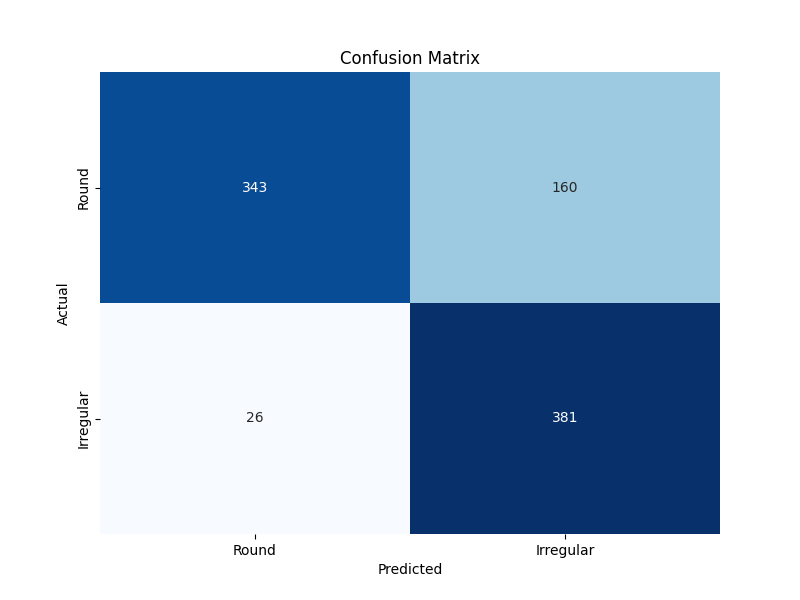

Accuracy: 0.795604 	F1 Score: 0.803797 	ROC AUC: 0.847099 	Specificity: 0.681909 	Sensitivity: 0.936118


In [21]:
calculate_val_metrics(np.array(mean_pred), np.array(true_labels))

In [22]:
# Store results
all_results_amb = []
mean_pred_amb = []
true_labels_amb = []
models = [model.to(device) for model in models]
# Inference
with torch.no_grad():
    for batch in eval_data_amb:
        images = batch['image']
        labels = batch['shape']  # Assuming 'shape' is the label

        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred_amb.append(np.mean(pred_probs))
        true_labels_amb.append(labels.item())
        all_results_amb.append({
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs)
        })

In [23]:
# Store results
all_results_amb_tr = []
mean_pred_amb_tr = []
true_labels_amb_tr = []
models = [model.to(device) for model in models]
# Inference
with torch.no_grad():
    for batch in tr_data_amb:
        images = batch['image']
        labels = batch['shape']  # Assuming 'shape' is the label

        pred_probs = predict(models, images)
        
        # Collect the results
        mean_pred_amb_tr.append(np.mean(pred_probs))
        true_labels_amb_tr.append(labels.item())
        all_results_amb_tr.append({
            'true_label': labels.item(),
            'predicted_probabilities': pred_probs,
            'predicted_class': int(np.mean(pred_probs) > 0.5),
            'std': np.std(pred_probs)
        })

In [24]:
good_results = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] == all_results[k]['predicted_class']]
bad_results = [all_results[k] for k in range(len(all_results)) if all_results[k]['true_label'] != all_results[k]['predicted_class']]

In [25]:
good_stds = [good_results[k]['std'] for k in range(len(good_results))]
bad_stds = [bad_results[k]['std'] for k in range(len(bad_results))]
amb_stds = [all_results_amb[k]['std'] for k in range(len(all_results_amb))]
amb_tr_stds = [all_results_amb_tr[k]['std'] for k in range(len(all_results_amb_tr))]

/tmp/ipykernel_596265/288152241.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='Category', y='Std', data=df, inner=None, palette='muted')
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 28.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 5.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 52.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home

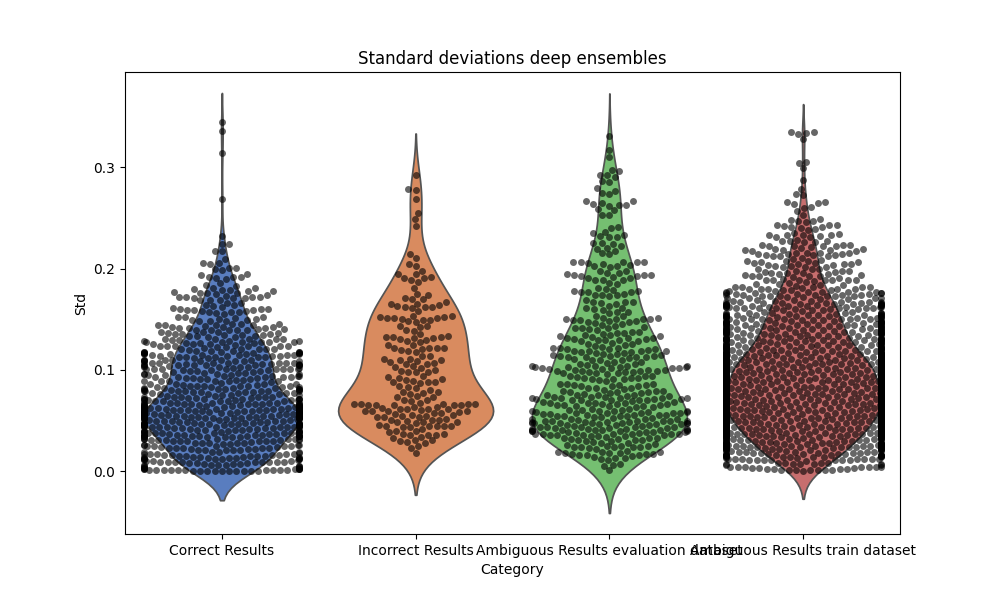

/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 26.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 51.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 24.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 48.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [26]:
# Prepare the data in a long-form DataFrame
df = pd.DataFrame({
    'Std': good_stds + bad_stds + amb_stds + amb_tr_stds,
    'Category': ['Correct Results'] * len(good_stds) + ['Incorrect Results'] * len(bad_stds) + ['Ambiguous Results evaluation dataset'] * len(amb_stds) + ['Ambiguous Results train dataset'] * len(amb_tr_stds)
})

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the violin plot
sns.violinplot(x='Category', y='Std', data=df, inner=None, palette='muted')

# Add the scatter points
sns.swarmplot(x='Category', y='Std', data=df, color='k', alpha=0.6)

# Show the plot
plt.title('Standard deviations deep ensembles')
plt.show()

/tmp/ipykernel_596265/1115309176.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Category', y='Std', data=df, palette='muted')
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 20.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 45.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 18.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/ve

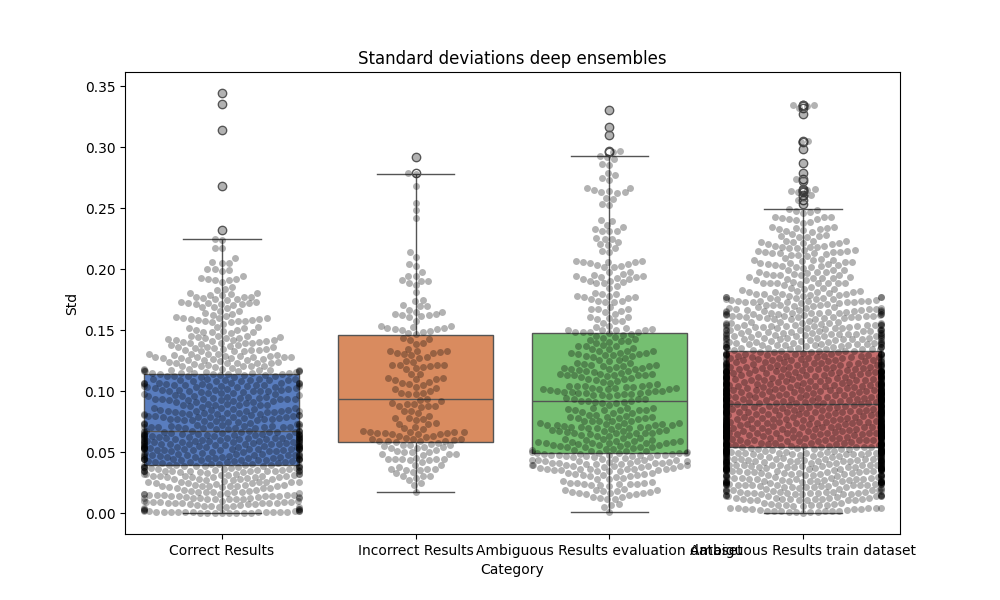

/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 19.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 44.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/psteinmetz/venv/lib/python3.10/site-packages/seaborn/categorical.py:3399: UserWarning: 42.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


In [28]:
plt.close('all')
# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Create the boxplot
sns.boxplot(x='Category', y='Std', data=df, palette='muted')
sns.swarmplot(x='Category', y='Std', data=df, color='k', alpha=0.3)
# Show the plot
plt.title('Standard deviations deep ensembles')
plt.show()
